# Seizure Prediction Project

 
 For my Capstone project I've chosen a data set from kaggle competition on Seizure prediction: https://www.kaggle.com/c/seizure-prediction

Seizures affect 0.5–1% of the world's population. They are produced by electrical impulses from throughout brain. Depending on the severity, a seizure may lead to unconsciousness, convulsions, which make activities like driving or swimming very dangerous. Currently, methods to forecast seizures are under development and the anti-epileptic drugs are not always effective and have many side-effects. The goal of the competition was to predict epileptic seizures in humans based on the intracranial EEG(electroencephalogram) recordings.

In case of effective prediction, it is theoretically possible to deliver responsive stimulation to the brain to abort the seizures. Additionally, it could reduce anxiety of patients associated with the persistent fear of not knowing when the next seizure will strike.
It turns out that seizures affect not only humans, but also animals:

Howbert JJ, Patterson EE, Stead SM, Brinkmann B, Vasoli V, Crepeau D, Vite CH, Sturges B, Ruedebusch V, Mavoori J, Leyde K, Sheffield WD, Litt B, Worrell GA (2014)
Forecasting seizures in dogs with naturally occurring epilepsy. PLoS One 9(1):e81920

This paper is available at: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0081920#pone-0081920-g002

Canine epilepsy appears to be a good model of human epilepsy with an advantage that iEEG data sets for dogs are much easier to acquire.
The analyzed data contains recordings for 5 dogs and 2 human patients and has size of approximately 100 Gb.
The data has some artifacts, for example, dog 5 has 15 electrodes(as opposed to 16 for other dogs), hence fewer features for prediction. See also, http://www.kaggle.com/c/seizure-detection/forums/t/9917/errors-in-data

In case of dogs, 16 electrodes were implanted in the brain, and the voltages were recorded continuously (ranging from 6.5 to 15 months, sampled at 400Hz).
Brain activity can be classified into 4 states: Interictal (between seizures, or baseline), Preictal (prior to seizure), Ictal (seizure), and Post-ictal (after seizures).
The postictal states have been excluded from the data.
The training data (for each dog) consists of 10-minutes segments classified either as interictal(0) or preictal(1). The test set consists of 10-min segments, which have to be classified either as 0 or 1.
The following picture shows iEEG plots when a seizure occurs:
 
<img src="./DogSz.png">
Once a seizure happens, the signals start to oscillate much faster. The idea is that the FFT of such signal should give us some good features for prediction.
The PLoS paper above suggests taking the energy of a signal in certain bands as features.
(There are 6 bands, hence 6 features for each segment/channel).
Additionally, we split each 10 minute segment for each channel into 10 1-minute segments and compute these spectral features. In this way, we obtain 16 channels x 10 segments x 6 =960 features
Then we perform a supervised learning, given that initially we are given a set of pre-classified inter-ictal/pre-ictal 10-minutes segments.
We try the LogisticRegression(LR); KBest+RF and SVM and plot learning curves for them.
The best model turned out to be simple LogisticRegression (LR). We draw a learning curve to check the perfomance of the LR.

<br>
I also tried adding eigenvalues of the correlation matrix for each segments as features ( The paper http://www-math.mit.edu/~edelman/publications/sample_eigenvalue.pdf suggests that they may be of some importance).
This provides 10 x 16 = 160 correlation features. However, I found that they make no difference in the prediction score.
I tried breaking 10-minute signals into 20 1-minute blocks (with 30-second overlaps). It seemed to improve the results a little bit (it changed the f1-score from (0.57 \pm 0.08) to (0.58 \pm 0.07) - 67% CI), i.e., the change was within the margin of error.
Also, I tried a different model with computing the FFT features for the whole 10-minute blocks (consequently with only 96 features per block).
The difference was 0.53 \pm 0.09 vs 0.57 \ pm 0.08 (LR - 35% of data was used for cross-validation).





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
import scipy.io as sio
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, roc_curve, auc
from sklearn import svm
import getfeatures3 as gf
import pandas as pd
%matplotlib inline
from sklearn.decomposition import PCA

<font color='blue' font size="3">
In order to test the models faster, I extracted the features from the original data and stored them in the file "features.mat"
The script "process_data.py" performs this pre-processing. I assume that the the current folder has the original iEEG data, the file with the correct classification of the test set "SzPrediction_answer_key.csv" 
as well as "features.mat" file.</font>

Next function is used later for drawing learning curves.<br>
Learning curves are used to determine how to improve a machine learning model (e.g., whether it has has a high bias or a high variance )<br>
Since the classes are highly unbalanced (there are much fewer examples with seizures than without), we use the "f1" score instead of the regular accuracy.

In [22]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')#  scoring='f1'
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score(f1)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score(f1)")

    plt.legend(loc="best")
    return plt

# Data Exploration

First we attempt to do data exploration by drawing scatter plots for different pairs of features. I was not able to find pairs which show clear separation between positive (intervals with seizures) and negative (intervals without seizures) examples (which probably explains why I was not able to achieve a good prediction score at the very end).

Next I looked at 5 most important features (which are correlated most with the predicted variable) and at the correlation between them. The correlation plots suggest that these features are somewhat correlated and that some feature reduction should be done. However, I was not able to achieve good predictions after going further in this direction.

(888L, 1121L)
0.0945945945946
[50, 162, 274, 386, 946]


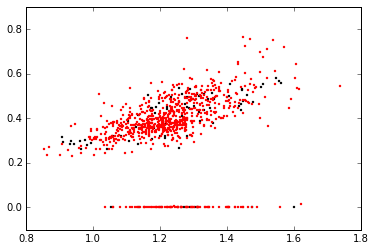

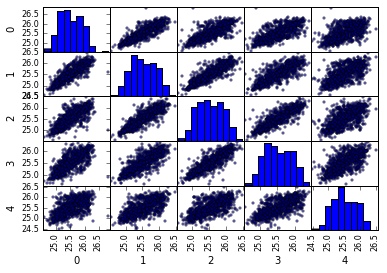

In [3]:
features=sio.loadmat("features.mat")
print features['f4'].shape # features for "Dog 4"
X=features['f4'][:,:-1] # 960 FFT features
y=features['f4'][:,-1] # classification labelX=features['f4'][:,:-1] # 960 FFT features
y=features['f4'][:,-1]# 0=interictal; 1=preictal
print float(sum(y))/len(y) # The ratio of 1's is only 10%, so the classes are highly unbalanced

# The separation between classes is not obvious from the scatter plot.

f1=X[:,3]
f2=X[:,7]
plt.scatter(f1[np.where(y == 1)[0]], f2[np.where(y == 1)[0]], s=2,  color='black')
plt.scatter(f1[np.where(y == 0)[0]], f2[np.where(y == 0)[0]], s=2,  color='red')
# Choose 5 best features and look whether they are correlated
clf=SelectKBest(f_regression,k=5)
top5=list(np.where(clf.fit(X,y).get_support()==True)[0])
print top5
pd.scatter_matrix(pd.DataFrame(X[:,top5]))
plt.figure()
plt.show()
# The features are somewhat correlated, so some 

# Model Evaluation 1
First, we try out LogisticRegression classifier and SVM. We use GridSearch to determine the optimal values of parameters in both cases.The introduction of a 10-fold cross validation doesn't affect the prediction results much. We use the data for Dog 4 and split the train data in the proportion 65%:35% for cross validation.As an alternative to the f1-score, we can use the AUC score, which is  the area under the ROC curve.

LogisticRegression(C=81.92, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95       933
        1.0       0.23      0.25      0.24        57

avg / total       0.91      0.91      0.91       990
0.239316239316


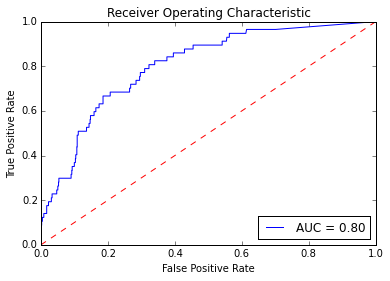

In [69]:
parameters = {'class_weight':(None,'auto'), 'C':[2**i/100.0 for i in range(14)]}
lr=LogisticRegression()# class_weight='auto'
cv = StratifiedShuffleSplit(y, n_iter=10, test_size=0.35, random_state=0)
clf = grid_search.GridSearchCV(lr, parameters, scoring='f1',cv=cv)
clf.fit(features['f4'][:,:-1], features['f4'][:,-1])
print clf.best_estimator_
y_true, y_pred = features['f4test'][:,-1], clf.predict(features['f4test'][:,:-1])
print classification_report(y_true, y_pred), f1_score(y_true, y_pred)


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true,  clf.predict_proba(features['f4test'][:,:-1])[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
parameters = {'class_weight':(None,'auto'), 'kernel':('linear', 'rbf'), 'C':[2**i/100.0 for i in range(14)]}
lr=svm.SVC()
cv = StratifiedShuffleSplit(y, n_iter=10, test_size=0.35, random_state=0)
clf = grid_search.GridSearchCV(lr, parameters, scoring='f1', cv=cv)
clf.fit(features['f4'][:,:-1], features['f4'][:,-1])
print clf.best_estimator_
y_true, y_pred = features['f4test'][:,-1], clf.predict(features['f4test'][:,:-1])
print classification_report(y_true, y_pred), f1_score(y_true, y_pred)

SVC(C=0.32, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
             precision    recall  f1-score   support

        0.0       0.95      0.96      0.96       933
        1.0       0.26      0.25      0.25        57

avg / total       0.91      0.92      0.92       990
0.252252252252


 # Model Evaluation 2
 
 It turns out that a combination of KBest with 200 best features, Random Forest Classifier and stratified cross-validation with 10 re-shuffles performs worse than simple logistic regression.The learning curve for the Logistic Regression shows high variance.

[ 0.24242424  0.10526316  0.10909091  0.25806452  0.10714286  0.3
  0.20338983  0.17857143  0.29508197  0.23333333]
f1 score for KBest+RF: 0.20 (+/- 0.14)( 95% CI)
[ 0.55045872  0.51764706  0.58947368  0.52941176  0.31111111  0.56179775
  0.54545455  0.61052632  0.46728972  0.48543689]
f1 score for Logistic Regression: 0.52 (+/- 0.16)( 95% CI)


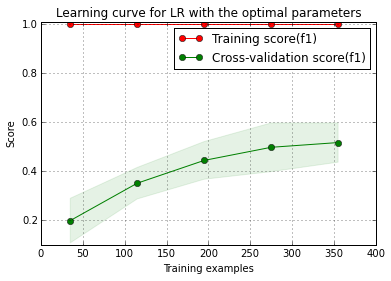

In [49]:
# Now we test several classifiers, we use 10 fold cross validation
X=features['f4'][:,:-1] 
y=features['f4'][:,-1]
clf = RandomForestClassifier(n_estimators=3000, min_samples_split=1, bootstrap=False, random_state=0, class_weight='auto')
estimator = Pipeline([('reduce', SelectKBest(f_regression, k=200)), ('rf', clf)])

cv = StratifiedShuffleSplit(y, n_iter=10, test_size=0.35, random_state=0)
scores = cross_validation.cross_val_score(clf, X, y, scoring='f1', cv=cv)
print scores
print("f1 score for KBest+RF: %0.2f (+/- %0.2f)( 95%% CI)" % (scores.mean(), scores.std() * 2))


cv = StratifiedShuffleSplit(y, n_iter=10, test_size=0.35, random_state=0)
clf = LogisticRegression(class_weight='auto',C=81.92) #
estimator=clf
scores = cross_validation.cross_val_score(clf, X, y, scoring='f1', cv=cv)
print scores
print("f1 score for Logistic Regression: %0.2f (+/- %0.2f)( 95%% CI)" % (scores.mean(), scores.std() * 2))
plot_learning_curve(estimator, 'KBest+LR', X, y, (0.1, 1.01), cv=cv)
plt.title('Learning curve for LR with the optimal parameters')
plt.show()


In [66]:
features['f4test'][:,:-1].shape

(990L, 1120L)